In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from interstellar import Tracks, DenseNetwork, set_seed, Network
import os

from tensorflow.keras.optimizers import SGD

In [2]:
seed = 101
name = 'network_09'
tracks = 'tracks_04b'
save_path = f'/home/ADF/ajl573/Data/interstellar_data/{name}'
load_path = f'/home/ADF/ajl573/Data/interstellar_data/{tracks}'

In [3]:
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [137]:
train = pd.read_csv(f'{load_path}/{tracks}_train.csv')

In [138]:
len(train)

7735733

In [139]:
t = Tracks(name=tracks)
t.set_data(train.sample(7735500, random_state=seed))

del train

In [140]:
t.get_data().head()

,evol_stage,initial_mass,initial_Yinit,initial_feh,initial_MLT,frac_age,effective_T,luminosity,log_g,surface_he4,surface_Z,star_feh,delta_nu_fit,initial_Zinit,gradient,log_star_age,log_radius
5933768,1,1.17,0.24,-0.2,1.5,0.381987,6180.6750,2.203866,4.280516,0.121770,0.004602,-0.536008,97.249210,0.008581,0.000138,0.219018,0.112780
334900,1,1.16,0.28,-0.3,1.7,0.996618,6587.1980,4.786881,4.050493,0.149323,0.003788,-0.607039,63.997060,0.006473,0.000463,0.490498,0.225884
7135268,2,1.18,0.28,-0.1,2.3,1.022719,6349.7030,4.278201,4.042870,0.184591,0.007162,-0.310150,65.216125,0.010205,0.000369,0.568727,0.233383
3251278,1,0.81,0.24,0.4,2.5,0.545067,4438.7354,0.223159,4.540280,0.201984,0.028536,0.311528,171.295750,0.033051,0.000317,1.309384,-0.096953
1224838,2,1.12,0.32,0.2,1.9,1.269763,5169.1978,3.214738,3.786232,0.309476,0.018507,0.182351,43.206272,0.018963,0.001241,0.760349,0.349985


In [141]:
len(t._data)

7735500

## Normalize

Let's choose the inputs and outputs and the normalise

In [142]:
x_cols = ['frac_age', 'initial_mass', 'initial_MLT', 'initial_Yinit', 'initial_Zinit']
y_cols = ['log_star_age', 'effective_T', 'radius', 'delta_nu_fit', 'star_feh']

In [143]:
t._data['radius'] = 10**t._data['log_radius']

In [144]:
factors, _df = t.normalize(loc='50%', scale='std', columns=x_cols+y_cols)

In [145]:
factors

,column,norm_column,loc,scale
0,frac_age,frac_age_norm,0.864502,0.414357
1,initial_mass,initial_mass_norm,1.000000,0.117963
2,initial_MLT,initial_MLT_norm,1.900000,0.337990
3,initial_Yinit,initial_Yinit_norm,0.280000,0.028033
4,initial_Zinit,initial_Zinit_norm,0.016932,0.010686
5,log_star_age,log_star_age_norm,0.790408,0.466882
6,effective_T,effective_T_norm,5566.810250,601.275379
7,radius,radius_norm,1.223533,0.502577
8,delta_nu_fit,delta_nu_fit_norm,100.727300,42.580915
9,star_feh,star_feh_norm,0.081136,0.360914


Round the loc and scale to 3 dp

In [146]:
factors = round(factors, 3)

In [147]:
factors

,column,norm_column,loc,scale
0,frac_age,frac_age_norm,0.865,0.414
1,initial_mass,initial_mass_norm,1.000,0.118
2,initial_MLT,initial_MLT_norm,1.900,0.338
3,initial_Yinit,initial_Yinit_norm,0.280,0.028
4,initial_Zinit,initial_Zinit_norm,0.017,0.011
5,log_star_age,log_star_age_norm,0.790,0.467
6,effective_T,effective_T_norm,5566.810,601.275
7,radius,radius_norm,1.224,0.503
8,delta_nu_fit,delta_nu_fit_norm,100.727,42.581
9,star_feh,star_feh_norm,0.081,0.361


In [148]:
factors, _df = t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
                           columns=x_cols+y_cols)
_df.head()

,frac_age_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,radius_norm,delta_nu_fit_norm,star_feh_norm
5933768,-1.166697,1.440678,-1.183432,-1.428571,-0.765323,-1.222660,1.020939,0.144177,-0.081675,-1.709165
334900,0.317917,1.355932,-0.591716,0.000000,-0.957022,-0.641333,1.697040,0.910981,-0.862590,-1.905926
7135268,0.380963,1.525424,1.183432,0.000000,-0.617730,-0.473818,1.302055,0.969230,-0.833961,-1.083518
3251278,-0.772786,-1.610169,1.775148,-1.428571,1.459168,1.112172,-1.876138,-0.843100,1.657283,0.638582
1224838,0.977687,1.016949,0.000000,1.428571,0.178444,-0.063494,-0.661282,2.017188,-1.350854,0.280749


In [149]:
del _df

In [150]:
t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
                           columns=x_cols+y_cols, inplace=True)

In [151]:
t.norm_factors.to_csv(os.path.join(save_path, 'tracks_04b_norm.csv'), index=False)

In [152]:
train = t.get_data([f'{col}_norm' for col in x_cols+y_cols]+['gradient'])
train.head()

,frac_age_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,radius_norm,delta_nu_fit_norm,star_feh_norm,gradient
5933768,-1.166697,1.440678,-1.183432,-1.428571,-0.765323,-1.222660,1.020939,0.144177,-0.081675,-1.709165,0.000138
334900,0.317917,1.355932,-0.591716,0.000000,-0.957022,-0.641333,1.697040,0.910981,-0.862590,-1.905926,0.000463
7135268,0.380963,1.525424,1.183432,0.000000,-0.617730,-0.473818,1.302055,0.969230,-0.833961,-1.083518,0.000369
3251278,-0.772786,-1.610169,1.775148,-1.428571,1.459168,1.112172,-1.876138,-0.843100,1.657283,0.638582,0.000317
1224838,0.977687,1.016949,0.000000,1.428571,0.178444,-0.063494,-0.661282,2.017188,-1.350854,0.280749,0.001241


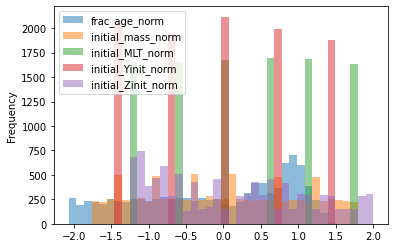

In [153]:
train.sample(n=10000).plot(kind='hist', y=[f'{col}_norm' for col in x_cols], bins=40, alpha=0.5)

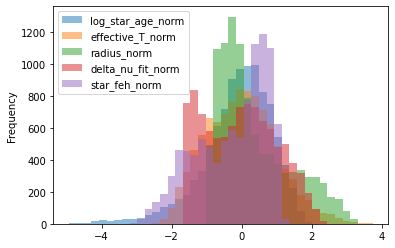

In [154]:
train.sample(n=10000).plot(kind='hist', y=[f'{col}_norm' for col in y_cols], bins=40, alpha=0.5)

Normalise training weights such that they are of order 1

In [155]:
train['weight'] = train['gradient']/train['gradient'].std()

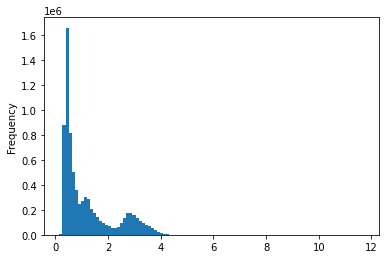

In [156]:
train['weight'].plot(kind='hist', bins=100)

Validation

In [157]:
val = pd.read_csv(f'{load_path}/{tracks}_val.csv')

In [158]:
t = Tracks()
t.set_data(val)

In [159]:
t._data['radius'] = 10**t._data['log_radius']

In [160]:
t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
            columns=x_cols+y_cols, inplace=True)

In [161]:
val = t.get_data([f'{col}_norm' for col in x_cols+y_cols])
val.head()

,frac_age_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,radius_norm,delta_nu_fit_norm,star_feh_norm
0,-2.034797,0.0,1.183432,-1.428571,-0.56619,-3.168209,0.329248,-0.693823,1.510279,-0.508290
1,-1.947274,0.0,1.183432,-1.428571,-0.56619,-2.278284,0.342871,-0.677155,1.455719,-0.520624
2,-1.913464,0.0,1.183432,-1.428571,-0.56619,-2.079786,0.348285,-0.671455,1.437332,-0.525418
3,-1.906711,0.0,1.183432,-1.428571,-0.56619,-2.044757,0.349368,-0.670330,1.433718,-0.526367
4,-1.879733,0.0,1.183432,-1.428571,-0.56619,-1.916647,0.353693,-0.665855,1.419407,-0.530137


In [162]:
del t

In [163]:
x_cols = [f'{col}_norm' for col in x_cols]
y_cols = [f'{col}_norm' for col in y_cols]

In [164]:
print(f'Length of training data = {len(train)}')
print(f'Length of validation data = {len(val)}')

Length of training data = 7735500
Length of validation data = 1933933


In [102]:
n_batches = np.arange(500, 2000)  # Select a range where number of batches is reasonable
r = (len(train)) % n_batches 

# Print whole multiples of training size
print(f'choose number of batches from:\n{n_batches[r==0]}')

choose number of batches from:
[ 500  540  573  675  750  764  810  900  955 1125 1146 1350 1500 1620
 1719 1910]


In [103]:
len(train)//764

10125

In [104]:
depth = 6
width = 128
activation = 'elu'
batch_size = len(train)//764
regularization_l2 = 1e-7
optimizer = SGD(0.0001, 0.999)
loss = 'mae'
metrics = ['mae']

In [105]:
def get_config(self):
    config = dict(
        name=self.name,
        model_filename=self.model_filename,
        history_filename=self.history_filename,
        optimizer=str(self.optimizer),
        loss=self.loss,
        metrics=self.metrics,
        x_cols=self.x_cols,
        y_cols=self.y_cols
        )
    return config

In [106]:
Network.get_config = get_config

In [107]:
network = DenseNetwork(path=save_path, name=name, depth=depth, width=width,
                       activation=activation, batch_size=batch_size, regularization_l2=regularization_l2)

In [108]:
network.build(len(x_cols), len(y_cols))

In [109]:
network.compile(optimizer=optimizer, loss=loss, metrics=metrics)
network.save()

In [110]:
fit_kw = {'sample_weight': train['weight'].to_numpy()}

In [165]:
network.train(train, x_cols, y_cols, epochs=200, validation_split=None, validation_data=val,
              callbacks=['checkpoint', 'tensorboard'], fit_kw=fit_kw)

  ...
    to  
  ['...']


In [166]:
network.save()

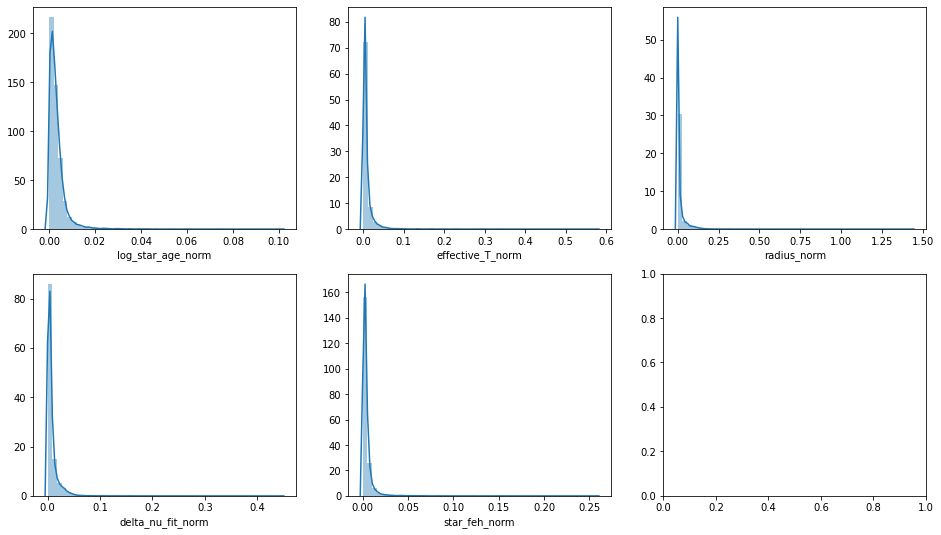

In [167]:
network.plot_metric(val.sample(20000), metric='absolute_error');

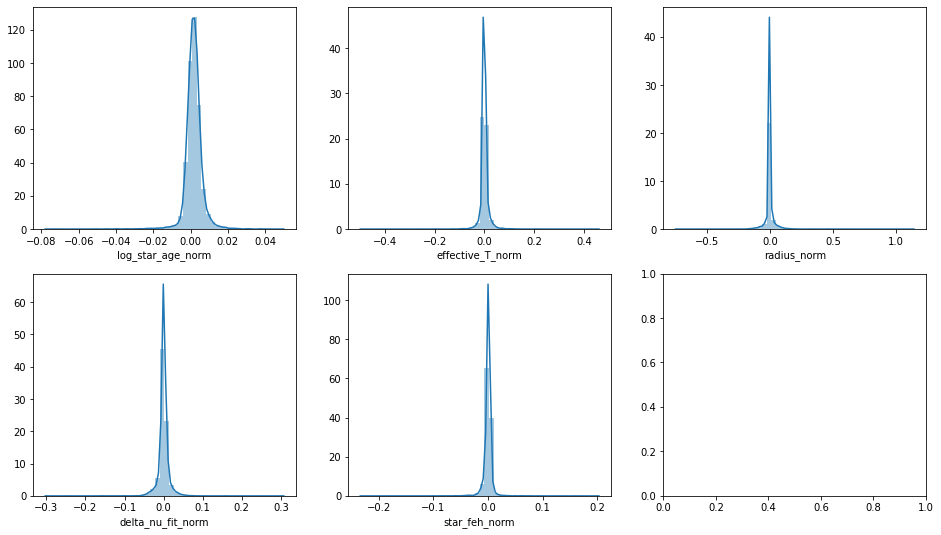

In [168]:
network.plot_metric(val.sample(20000), metric='error');

In [169]:
scores = network.scores(val.sample(20000))
scores

,log_star_age_norm,effective_T_norm,radius_norm,delta_nu_fit_norm,star_feh_norm
count,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04,2.000000e+04
mean,3.340476e-03,8.216357e-03,1.380759e-02,7.612267e-03,3.943781e-03
std,4.156779e-03,1.787857e-02,3.473380e-02,1.201024e-02,6.702039e-03
min,1.848960e-07,3.305488e-07,8.368369e-08,1.012747e-07,6.598697e-08
25%,1.141025e-03,1.784393e-03,1.325321e-03,1.700368e-03,1.164194e-03
50%,2.402411e-03,3.949139e-03,2.889986e-03,4.028196e-03,2.447846e-03
75%,4.172865e-03,8.130691e-03,9.309210e-03,8.603680e-03,4.361064e-03
max,9.975150e-02,5.171859e-01,1.019967e+00,3.711953e-01,2.458104e-01


In [170]:
scale_scores = factors.loc[5:, 'scale'].to_numpy() * scores

In [171]:
log_cols = [col for col in scale_scores.columns if 'log' in col]
log_cols

scale_scores[[col[4:] for col in log_cols]] = scale_scores[log_cols] * np.log(10.0)

scale_scores.loc['std'].round(5)

log_star_age_norm     0.00194
effective_T_norm     10.74994
radius_norm           0.01747
delta_nu_fit_norm     0.51141
star_feh_norm         0.00242
star_age_norm         0.00447
Name: std, dtype: float64

In [172]:
train['log_g_norm'] = np.log10(train['initial_mass_norm']) - 2 * train['log_radius_norm']

KeyError: 'log_radius_norm'

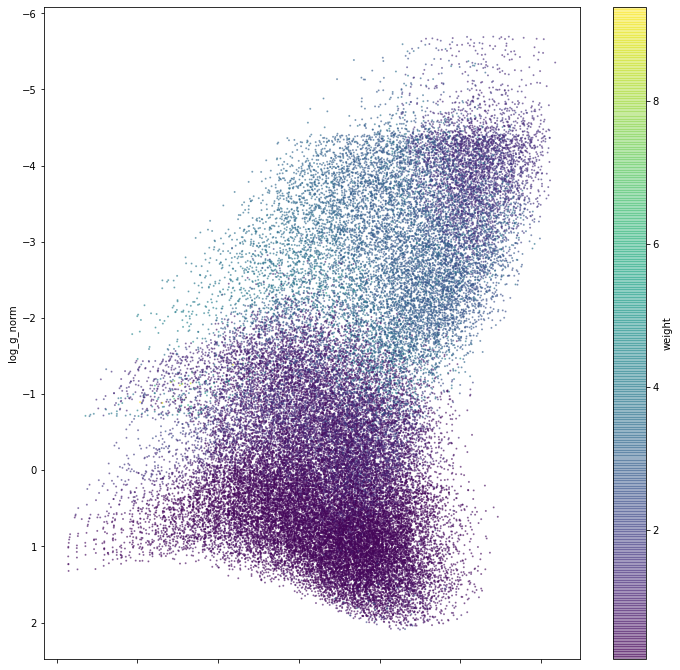

In [79]:
ax = train.sample(100000).plot(kind='scatter', x='effective_T_norm', y='log_g_norm',
                              c='weight', cmap='viridis', s=1, figsize=(12, 12), alpha=0.5)
ax.invert_xaxis()
ax.invert_yaxis();